# Energieverbrauchsvorhersage - Stacking Experiment


## Problemstellung
Das Ziel ist die Vorhersage des Energieverbrauchs unter Verwendung von verschiedenen Deep Learning-Modellen und Stacking-Techniken, um dem gegeben Extrapolationsproblem entgegenzuwirken.

## Daten
- **energy_consumed:** Die Zielvariable variiert von ca. 0.00000005 bis 0.00032 kWh
- **num_num_features:** Die Anzahl der numerischen und kategorischen Features reichen von 0 bis 7 bzw. 0 bis 14
- **num_cat_features:** Die Anzahl kategorischen Features reichen von 0 bis 14
- **number_of_instances:** Die Größe der Datensätze variiert von 9000 bis 320000 Instanzen
- **model:** Die verwendeten Algorithmen sind kategorisch dargestellt, mit Werten von 0 bis 4

## Vorgehen:

### Datenanalyse und Vorverarbeitung
Hier führen wir die Exploration und Vorverarbeitung der Daten durch. Dies beinhaltet überwiegend die Kodierung kategorischer Features.

### Modellbildung
In diesem Abschnitt bauen wir verschiedene Deep Learning-Modelle und verwenden die Stacking-Technik, um die Vorhersagegenauigkeit zu erhöhen. Wir verwenden die folgenden Schritte:

- Schritt 1: Baseline Modelle trainieren
- Schritt 1: Metamodell trainieren mittels der Baseline Vorhersagen


## Vorbereitung

### Imports

In [ ]:
# Hardwareinfo
!nvidia-smi

Mon Jan 22 20:18:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              26W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/hollerith-energy-ml/data/energy_predcition_training-data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Daten vorbereiten
- Codierung der kategorischen Features
- Skalierung der numerischen Features
- Aufteilung in Trainings- und Testsets

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('energy_consumed', axis=1)
y = df['energy_consumed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = ['num_num_features', 'num_cat_features', 'number_of_instances']
cat_features = ['model']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing importü StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((10040, 8), (2510, 8))

## Hilfsfunktion

In [ ]:
def format_energy(value_in_kwh):
    units = [
        ("TWh", 1e-9),
        ("GWh", 1e-6),
        ("MWh", 1e-3),
        ("kWh", 1),
        ("Wh", 1e3),
        ("mWh", 1e6),
        ("µWh", 1e9),
        ("nWh", 1e12),
        ("pWh", 1e15)
    ]

    for unit, factor in units:
        if value_in_kwh * factor >= 1:
            return f"{value_in_kwh * factor:.2f} {unit}"

    return "0 µWh"

model_category_mapping = {
    'Decision Tree': 0,
    'Gaussian Naive Bayes': 1,
    'K-Nearest Neighbors': 2,
    'Logistic Regression': 3,
    'Random Forest': 4
}

def predict_and_display_energy_consumption(encoder, num_num_features, num_cat_features, number_of_instances):
    input_data = {
        'num_num_features': [num_num_features] * 5,
        'num_cat_features': [num_cat_features] * 5,
        'number_of_instances': [number_of_instances] * 5,
        'model': list(range(5))
    }

    input_df = pd.DataFrame(input_data)
    input_processed = encoder.transform(input_df)

    all_models = {**base_models, 'Stacking Ensemble': stacking_model}

    predictions = {}
    for model_category in range(5):
        for name, model in all_models.items():
            prediction = model.predict(input_processed[model_category].reshape(1, -1))[0]
            converted_prediction = format_energy(prediction)
            model_category_name = list(model_category_mapping.keys())[list(model_category_mapping.values()).index(model_category)]
            predictions[(model_category_name, name)] = converted_prediction

    return predictions

## Experiment 1

**Basis-Modelle:**
- Random Forest Regressor: Da es gute Ergebnisse auf den Trainingsdaten leiferte
- Gradient Boosting Regressor: da gut für Regressionsaufgaben und kann nichtlineare Muster erkennen
- Lineare Regression: um die Extrapolationsfähigkeit zu nutzen

**Meta-Modell:**
- Lineare Regression: Vorhersagen gewichten

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

base_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression()
}

# Kreuzvalidierung einrichten
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Bewertung der Basis-Modelle
model_scores = {}
for name, model in base_models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=kf, scoring='neg_mean_squared_error')
    model_scores[name] = np.mean(np.sqrt(-cv_scores))

model_scores

{'Random Forest': 4.140615694231319e-06,
 'Gradient Boosting': 5.288152399900951e-06,
 'Linear Regression': 2.793982251057454e-05}

In [ ]:
# Hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = {
    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 4]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

tuned_models = {}
for name, model in base_models.items():
    if name != "Linear Regression":
        grid_search = GridSearchCV(model, param_grid[name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_processed, y_train)
        tuned_models[name] = grid_search.best_estimator_
    else:
        tuned_models[name] = model

tuned_model_details = {name: model.get_params() for name, model in tuned_models.items()}
tuned_model_details

{'Random Forest': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'criterion': 'squared_error',
  'max_depth': 10,
  'max_features': 1.0,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 150,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 'Gradient Boosting': {'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.2,
  'loss': 'squared_error',
  'max_depth': 5,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 150,
  'n_iter_no_change': None,
  'random_state': 42,
  'subsample': 1.0,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 0,
  'warm_start': False},
 'Linear Regression': {'copy_X': True,
  'fit_intercept

In [ ]:
from sklearn.ensemble import StackingRegressor

# Basis-Modelle mit gefundenen Hyperparametern
base_models['Random Forest'].set_params(**tuned_model_details['Random Forest'])
base_models['Gradient Boosting'].set_params(**tuned_model_details['Gradient Boosting'])

for model in base_models.values():
    model.fit(X_train_processed, y_train)

# Stacking-Modell
stacking_model = StackingRegressor(
    estimators=[(name, model) for name, model in base_models.items()],
    final_estimator=LinearRegression()
)

stacking_model.fit(X_train_processed, y_train)

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=150,
                                                     random_state=42)),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(learning_rate=0.2,
                                                         max_depth=5,
                                                         n_estimators=150,
                                                         random_state=42)),
                              ('Linear Regression', LinearRegression())],
                  final_estimator=LinearRegression())

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = stacking_model.predict(X_test_processed)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE des Stacking-Modell: {rmse}")
print(f"R^2 des Stacking-Modell: {r2}")

RMSE des Stacking-Modell: 3.7408045445241383e-06
R^2 des Stacking-Modell: 0.9906563965372944


Feature-Wichtigkeiten im Random Forest:
Feature 8: 0.3525
Feature 3: 0.3072
Feature 1: 0.2881
Feature 2: 0.0279
Feature 7: 0.0230
Feature 4: 0.0012
Feature 5: 0.0001
Feature 6: 0.0001


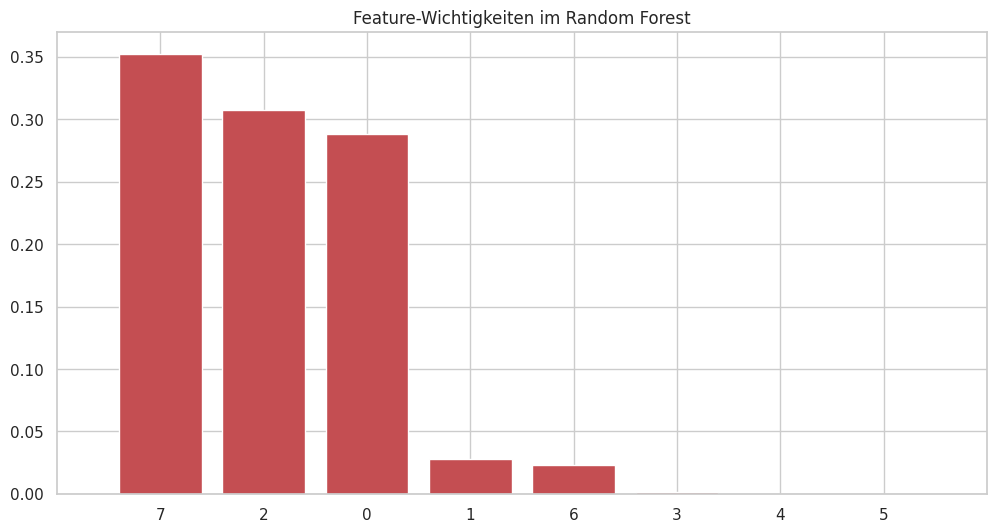

In [ ]:
# Analyse der Feature-Wichtigkeit für Random Forest
import matplotlib.pyplot as plt
import numpy as np

rf_feature_importance = base_models['Random Forest'].feature_importances_
indices = np.argsort(rf_feature_importance)[::-1]

print("Feature-Wichtigkeiten im Random Forest:")
for i, index in enumerate(indices):
    feature_name = f"Feature {index + 1}"
    importance = rf_feature_importance[index]
    print(f"{feature_name}: {importance:.4f}")

plt.figure(figsize=(12, 6))
plt.title("Feature-Wichtigkeiten im Random Forest")
plt.bar(range(X_train_processed.shape[1]), rf_feature_importance[indices],
       color="r", align="center")
plt.xticks(range(X_train_processed.shape[1]), indices)
plt.xlim([-1, X_train_processed.shape[1]])
plt.show()


### Vorhersagen auf unbekannte Daten

In [ ]:
final_predictions = predict_and_display_energy_consumption(
    encoder=preprocessor,
    num_num_features=5000,
    num_cat_features=1300,
    number_of_instances=10000
)

output_lines = [f"Modell Kategorie {model_category}, {model_name}: {prediction}" for (model_category, model_name), prediction in final_predictions.items()]
output_paragraphs = ['\n'.join(output_lines[i:i+4]) for i in range(0, len(output_lines), 4)]
print('\n\n'.join(output_paragraphs))

Modell Kategorie Decision Tree, Random Forest: 2.35 mWh
Modell Kategorie Decision Tree, Gradient Boosting: 2.16 mWh
Modell Kategorie Decision Tree, Linear Regression: 116.04 mWh
Modell Kategorie Decision Tree, Stacking Ensemble: 2.21 mWh

Modell Kategorie Gaussian Naive Bayes, Random Forest: 198.01 µWh
Modell Kategorie Gaussian Naive Bayes, Gradient Boosting: 25.52 µWh
Modell Kategorie Gaussian Naive Bayes, Linear Regression: 112.85 mWh
Modell Kategorie Gaussian Naive Bayes, Stacking Ensemble: 74.75 µWh

Modell Kategorie K-Nearest Neighbors, Random Forest: 148.85 µWh
Modell Kategorie K-Nearest Neighbors, Gradient Boosting: 0 µWh
Modell Kategorie K-Nearest Neighbors, Linear Regression: 114.67 mWh
Modell Kategorie K-Nearest Neighbors, Stacking Ensemble: 0 µWh

Modell Kategorie Logistic Regression, Random Forest: 18.24 mWh
Modell Kategorie Logistic Regression, Gradient Boosting: 16.59 mWh
Modell Kategorie Logistic Regression, Linear Regression: 127.79 mWh
Modell Kategorie Logistic Regress

## Experiment 2

**Basis-Modelle:**
- Random Forest Regressor: Da es gute Ergebnisse auf den Trainingsdaten leiferte
- Gradient Boosting Regressor: da gut für Regressionsaufgaben und kann nichtlineare Muster erkennen
- Lineare Regression: um die Extrapolationsfähigkeit zu nutzen
- Ridge

**Meta-Modell:**
- H2O

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

base_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_scores = {}
for name, model in base_models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=kf, scoring='neg_mean_squared_error')
    model_scores[name] = np.mean(np.sqrt(-cv_scores))

model_scores

{'Random Forest': 4.140615694231319e-06,
 'Gradient Boosting': 5.288152399900951e-06,
 'Linear Regression': 2.793982251057454e-05,
 'Ridge Regression': 2.7939732208258812e-05}

In [ ]:
param_grid = {
    "Random Forest": {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 4]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "Ridge Regression": {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    },
}

tuned_models = {}
for name, model in base_models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_processed, y_train)
        tuned_models[name] = grid_search.best_estimator_
    else:
        tuned_models[name] = model

tuned_model_details = {name: model.get_params() for name, model in tuned_models.items()}
tuned_model_details

{'Random Forest': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'criterion': 'squared_error',
  'max_depth': 10,
  'max_features': 1.0,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 150,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 'Gradient Boosting': {'alpha': 0.9,
  'ccp_alpha': 0.0,
  'criterion': 'friedman_mse',
  'init': None,
  'learning_rate': 0.2,
  'loss': 'squared_error',
  'max_depth': 5,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 150,
  'n_iter_no_change': None,
  'random_state': 42,
  'subsample': 1.0,
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': 0,
  'warm_start': False},
 'Linear Regression': {'copy_X': True,
  'fit_intercept

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=8422e4997a2d340643b2109de2a8c2956572b6902d364e2afd8a7bbcab6244b1
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

h2o.init()

meta_X_train = np.column_stack([model.predict(X_train_processed) for model in models_to_train])
meta_X_test = np.column_stack([model.predict(X_test_processed) for model in models_to_train])

train_df = pd.DataFrame(meta_X_train, columns=[f'feature_{i}' for i in range(meta_X_train.shape[1])])
train_df['target'] = y_train.to_numpy()

train_h2o = h2o.H2OFrame(train_df)

automl = H2OAutoML(max_models=10, seed=42, include_algos=["DeepLearning"])
automl.train(x=train_h2o.columns[:-1], y='target', training_frame=train_h2o)

best_dl_model = automl.leader

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 mins 32 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_unknownUser_pjer56
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12.75 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
best_model_type = best_dl_model.algo
print(f"Das ausgewählte Modell ist vom Typ: {best_model_type}")
model_params = best_dl_model.params
print(f"Modell Hyperparameter:\n{model_params}")

Das ausgewählte Modell ist vom Typ: deeplearning
Modell Hyperparameter:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'DeepLearning_grid_1_AutoML_1_20240123_10412_model_3', 'type': 'Key<Model>', 'URL': '/3/Models/DeepLearning_grid_1_AutoML_1_20240123_10412_model_3'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240123_10412_training_Key_Frame__upload_976f95d51d4176dcb0f7771e9944a60.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240123_10412_training_Key_Frame__upload_976f95d51d4176dcb0f7771e9944a60.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240123_10412_training_Key_Frame__upload_976f95d51d4176dcb0f7771e9944a60.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_2024012

In [ ]:
feature_importance = best_dl_model.varimp()
print(feature_importance)

[('feature_0', 1.0, 1.0, 0.2789536001069976), ('feature_1', 0.9155796766281128, 0.9155796766281128, 0.25540424698021275), ('feature_2', 0.8856992125511169, 0.8856992125511169, 0.24706898395306695), ('feature_3', 0.7835466861724854, 0.7835466861724854, 0.21857316895972265)]


In [ ]:
test_df = pd.DataFrame(meta_X_test, columns=[f'feature_{i}' for i in range(meta_X_test.shape[1])])
test_h2o = h2o.H2OFrame(test_df)

predictions = best_dl_model.predict(test_h2o)

predictions_df = h2o.as_list(predictions)

mse = mean_squared_error(y_test, predictions_df)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions_df)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
RMSE: 4.71593160868976e-06
R²: 0.9851502425105056


In [ ]:
def format_energy(value_in_kwh):
    units = [
        ("TWh", 1e-9),
        ("GWh", 1e-6),
        ("MWh", 1e-3),
        ("kWh", 1),
        ("Wh", 1e3),
        ("mWh", 1e6),
        ("µWh", 1e9),
        ("nWh", 1e12),
        ("pWh", 1e15)
    ]

    for unit, factor in units:
        if value_in_kwh * factor >= 1:
            return f"{value_in_kwh * factor:.2f} {unit}"

    return "0 µWh"

def predict_and_display_energy_consumption(encoder, num_num_features, num_cat_features, number_of_instances, h2o_model, base_models):
    input_data = {
        'num_num_features': [num_num_features] * 5,
        'num_cat_features': [num_cat_features] * 5,
        'number_of_instances': [number_of_instances] * 5,
        'model': list(range(5))
    }

    input_df = pd.DataFrame(input_data)
    input_processed = encoder.transform(input_df)

    predictions = {}
    for model_category in range(5):
        # Vorhersagen für Basis-Modelle
        for name, model in base_models.items():
            prediction = model.predict(input_processed[model_category].reshape(1, -1))[0]
            converted_prediction = format_energy(prediction)
            model_category_name = list(model_category_mapping.keys())[model_category]
            predictions[(model_category_name, name)] = converted_prediction

        # Vorhersage für das H2O-Modell
        meta_features = np.column_stack([model.predict(input_processed[model_category].reshape(1, -1)) for model in base_models.values()])
        meta_features_df = pd.DataFrame(meta_features, columns=[f'feature_{i}' for i in range(meta_features.shape[1])])
        meta_features_h2o = h2o.H2OFrame(meta_features_df)
        h2o_prediction = h2o_model.predict(meta_features_h2o).as_data_frame().iloc[0, 0]
        converted_h2o_prediction = format_energy(h2o_prediction)
        predictions[(model_category_name, 'Stacking Ensemble')] = converted_h2o_prediction

    return predictions

In [ ]:
final_predictions = predict_and_display_energy_consumption(
    encoder=preprocessor,
    num_num_features=50000,
    num_cat_features=13000,
    number_of_instances=1000000,
    h2o_model=best_dl_model,
    base_models=tuned_models
)

output_lines = [f"Modell Kategorie {model_category}, {model_name}: {prediction}" for (model_category, model_name), prediction in final_predictions.items()]
output_paragraphs = ['\n'.join(output_lines[i:i+5]) for i in range(0, len(output_lines), 5)]
print('\n\n'.join(output_paragraphs))


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |███████████████

In [ ]:
model=best_dl_model
model.summary()

,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,4,Input,10.0,,,,,,,,,
,2,100,RectifierDropout,0.0,0.0,0.0,0.0033349,0.0283144,0.0,0.0101934,0.1313232,0.5018093,0.0070797
,3,1,Linear,,0.0,0.0,0.0001045,0.0001039,0.0,-0.0002658,0.1410509,0.0205677,0.0000000


In [ ]:
hidden_layers = best_dl_model.deepfeatures(train_h2o, layer=0)
hidden_layers

deepfeatures progress: |█████████████████████████████████████████████████████████| (done) 100%


DF.L1.C1,DF.L1.C2,DF.L1.C3,DF.L1.C4,DF.L1.C5,DF.L1.C6,DF.L1.C7,DF.L1.C8,DF.L1.C9,DF.L1.C10,DF.L1.C11,DF.L1.C12,DF.L1.C13,DF.L1.C14,DF.L1.C15,DF.L1.C16,DF.L1.C17,DF.L1.C18,DF.L1.C19,DF.L1.C20,DF.L1.C21,DF.L1.C22,DF.L1.C23,DF.L1.C24,DF.L1.C25,DF.L1.C26,DF.L1.C27,DF.L1.C28,DF.L1.C29,DF.L1.C30,DF.L1.C31,DF.L1.C32,DF.L1.C33,DF.L1.C34,DF.L1.C35,DF.L1.C36,DF.L1.C37,DF.L1.C38,DF.L1.C39,DF.L1.C40,DF.L1.C41,DF.L1.C42,DF.L1.C43,DF.L1.C44,DF.L1.C45,DF.L1.C46,DF.L1.C47,DF.L1.C48,DF.L1.C49,DF.L1.C50,DF.L1.C51,DF.L1.C52,DF.L1.C53,DF.L1.C54,DF.L1.C55,DF.L1.C56,DF.L1.C57,DF.L1.C58,DF.L1.C59,DF.L1.C60,DF.L1.C61,DF.L1.C62,DF.L1.C63,DF.L1.C64,DF.L1.C65,DF.L1.C66,DF.L1.C67,DF.L1.C68,DF.L1.C69,DF.L1.C70,DF.L1.C71,DF.L1.C72,DF.L1.C73,DF.L1.C74,DF.L1.C75,DF.L1.C76,DF.L1.C77,DF.L1.C78,DF.L1.C79,DF.L1.C80,DF.L1.C81,DF.L1.C82,DF.L1.C83,DF.L1.C84,DF.L1.C85,DF.L1.C86,DF.L1.C87,DF.L1.C88,DF.L1.C89,DF.L1.C90,DF.L1.C91,DF.L1.C92,DF.L1.C93,DF.L1.C94,DF.L1.C95,DF.L1.C96,DF.L1.C97,DF.L1.C98,DF.L1.C99,DF.L1.C100
0.476866,0.206894,0.450783,0.649465,0.539621,0.179717,0.40628,0.464371,0.591009,0.345847,0.844423,0.632539,0.779635,0.491806,0.427308,0.480988,0.293482,0.596271,0.413662,0.390864,0.749717,0.445975,0.309583,0.450759,0.493889,0.688875,0.517312,0.719213,0.20324,0.694822,0.667202,0.470412,0.401534,0.677126,0.591005,0.213191,0.365171,0.525412,0.64191,0.62637,0.50403,0.377655,0.584738,0.568365,0.538596,0.62458,0.550305,0.156256,0.324684,0.256291,0.599857,0.561941,0.484416,0.231673,0.417029,0.632142,0.422291,0.698298,0.296374,0.309958,0.706764,0.724398,0.72156,0.43064,0.124262,0.477825,0.639924,0.561492,0.568198,0.546074,0.550986,0.311592,0.447869,0.544299,0.629252,0.557639,0.699405,0.484068,0.57992,0.263858,0.392426,0.829131,0.279419,0.611305,0.500395,0.501034,0.516754,0.446399,0.302181,0.408349,0.2401,0.173322,0.360124,0.487374,0.55881,0.299605,0.366409,0.569901,0.550494,0.424736
0.477317,0.280099,0.441929,0.617288,0.519714,0.266042,0.41942,0.450049,0.552145,0.385475,0.744338,0.612708,0.696234,0.492979,0.441851,0.507381,0.340426,0.573147,0.430916,0.415872,0.670374,0.465169,0.359586,0.4616,0.506406,0.6452,0.516537,0.657574,0.287249,0.626406,0.603958,0.466854,0.432003,0.625039,0.565623,0.287412,0.399658,0.541953,0.608491,0.604101,0.491838,0.402203,0.556971,0.555472,0.532367,0.559124,0.552426,0.249121,0.381221,0.326268,0.568427,0.552486,0.48559,0.2997,0.417678,0.607292,0.443875,0.666979,0.353408,0.366634,0.644096,0.644065,0.647085,0.431369,0.226893,0.483456,0.620899,0.539412,0.560657,0.518868,0.535126,0.368285,0.480039,0.550057,0.591539,0.52698,0.65535,0.495579,0.551691,0.324845,0.422938,0.723827,0.348193,0.596786,0.488226,0.49475,0.51174,0.442767,0.351048,0.422419,0.309533,0.254511,0.407451,0.503698,0.537192,0.355856,0.385372,0.545199,0.542581,0.431506
0.430792,0.844291,0.21881,0.407217,0.285391,0.97523,0.447026,0.171927,0.138119,0.701054,0,0.556361,0,0.484468,0.540933,0.848335,0.6734,0.382539,0.531024,0.602757,0,0.664165,0.756833,0.546111,0.673279,0.303067,0.540185,0.10241,1.01847,0,0,0.374151,0.697945,0.178785,0.3409,0.879865,0.67191,0.803213,0.34038,0.510869,0.313586,0.551029,0.303553,0.465938,0.501075,0,0.65273,1.01729,0.917633,0.940552,0.272944,0.505037,0.480383,0.826736,0.278753,0.486329,0.620161,0.50022,0.83495,0.87961,0.0640937,0,0,0.319953,1.08314,0.540833,0.557628,0.327804,0.569481,0.190697,0.388302,0.866509,0.851718,0.693611,0.248035,0.173231,0.323887,0.641123,0.262343,0.825806,0.689262,0,0.968292,0.554018,0.323948,0.407817,0.466666,0.297718,0.741396,0.460532,0.892748,0.898098,0.850295,0.713407,0.310118,0.829867,0.432174,0.302838,0.500999,0.411288
0.475253,0.247348,0.44025,0.634063,0.525619,0.229905,0.41182,0.452342,0.566636,0.369103,0.785181,0.624456,0.727473,0.489785,0.435017,0.499991,0.318573,0.586294,0.42007,0.407143,0.698772,0.461484,0.336032,0.454937,0.504409,0.66553,0.521613,0.682302,0.253943,0.650813,0.627196,0.466635,0.417365,0.645862,0.574131,0.256574,0.386629,0.537966,0.620042,0.615127,0.496441,0.388659,0.568402,0.558507,0.532509,0.58059,0

In [ ]:
hidden_layer_output = best_dl_model.deepfeatures(test_h2o, layer=0)
hidden_layer_output

deepfeatures progress: |█████████████████████████████████████████████████████████| (done) 100%


DF.L1.C1,DF.L1.C2,DF.L1.C3,DF.L1.C4,DF.L1.C5,DF.L1.C6,DF.L1.C7,DF.L1.C8,DF.L1.C9,DF.L1.C10,DF.L1.C11,DF.L1.C12,DF.L1.C13,DF.L1.C14,DF.L1.C15,DF.L1.C16,DF.L1.C17,DF.L1.C18,DF.L1.C19,DF.L1.C20,DF.L1.C21,DF.L1.C22,DF.L1.C23,DF.L1.C24,DF.L1.C25,DF.L1.C26,DF.L1.C27,DF.L1.C28,DF.L1.C29,DF.L1.C30,DF.L1.C31,DF.L1.C32,DF.L1.C33,DF.L1.C34,DF.L1.C35,DF.L1.C36,DF.L1.C37,DF.L1.C38,DF.L1.C39,DF.L1.C40,DF.L1.C41,DF.L1.C42,DF.L1.C43,DF.L1.C44,DF.L1.C45,DF.L1.C46,DF.L1.C47,DF.L1.C48,DF.L1.C49,DF.L1.C50,DF.L1.C51,DF.L1.C52,DF.L1.C53,DF.L1.C54,DF.L1.C55,DF.L1.C56,DF.L1.C57,DF.L1.C58,DF.L1.C59,DF.L1.C60,DF.L1.C61,DF.L1.C62,DF.L1.C63,DF.L1.C64,DF.L1.C65,DF.L1.C66,DF.L1.C67,DF.L1.C68,DF.L1.C69,DF.L1.C70,DF.L1.C71,DF.L1.C72,DF.L1.C73,DF.L1.C74,DF.L1.C75,DF.L1.C76,DF.L1.C77,DF.L1.C78,DF.L1.C79,DF.L1.C80,DF.L1.C81,DF.L1.C82,DF.L1.C83,DF.L1.C84,DF.L1.C85,DF.L1.C86,DF.L1.C87,DF.L1.C88,DF.L1.C89,DF.L1.C90,DF.L1.C91,DF.L1.C92,DF.L1.C93,DF.L1.C94,DF.L1.C95,DF.L1.C96,DF.L1.C97,DF.L1.C98,DF.L1.C99,DF.L1.C100
0.476524,0.351325,0.43057,0.58709,0.498779,0.351123,0.43165,0.434156,0.513435,0.425088,0.645276,0.59409,0.612404,0.492538,0.455857,0.535056,0.386099,0.551709,0.446371,0.441731,0.58972,0.486671,0.40743,0.471261,0.520296,0.603224,0.518462,0.596465,0.370875,0.557034,0.540086,0.46255,0.460741,0.573207,0.539062,0.360963,0.434825,0.559179,0.57408,0.5832,0.479673,0.425198,0.529588,0.541111,0.524724,0.492005,0.556367,0.340544,0.43685,0.396498,0.535787,0.542237,0.48506,0.366534,0.416451,0.584673,0.466162,0.63709,0.408258,0.421337,0.581714,0.562318,0.572821,0.429933,0.329379,0.490875,0.604129,0.51733,0.553564,0.491644,0.520014,0.425857,0.5132,0.557871,0.554447,0.493894,0.612963,0.506876,0.522889,0.384257,0.453536,0.620639,0.416671,0.582229,0.476221,0.488743,0.507247,0.437465,0.398904,0.434922,0.377032,0.333891,0.453917,0.521924,0.515675,0.411477,0.402156,0.518723,0.532911,0.436783
0.483533,0.3507,0.454352,0.582611,0.511074,0.344463,0.444425,0.46231,0.533681,0.425043,0.651939,0.577442,0.630776,0.492383,0.457919,0.512822,0.39109,0.556961,0.449402,0.446064,0.604305,0.482965,0.402923,0.468907,0.510522,0.605817,0.518786,0.609786,0.358386,0.577154,0.563524,0.473291,0.452516,0.579641,0.540821,0.35939,0.436822,0.535933,0.572102,0.569801,0.495411,0.430576,0.536577,0.535303,0.517971,0.528659,0.544529,0.332039,0.418304,0.38647,0.54159,0.53495,0.484054,0.367111,0.440062,0.574687,0.467009,0.624428,0.398106,0.405138,0.597738,0.587179,0.596047,0.447533,0.321964,0.49241,0.591987,0.524206,0.541211,0.513142,0.525888,0.41922,0.49343,0.543739,0.564217,0.509384,0.612905,0.495906,0.534107,0.377825,0.449545,0.648613,0.402344,0.568061,0.489448,0.496701,0.509203,0.455851,0.396456,0.445851,0.366975,0.330574,0.43947,0.510942,0.526586,0.405236,0.417277,0.523227,0.524733,0.447753
0.476719,0.21866,0.448906,0.644451,0.536158,0.193744,0.408292,0.4617,0.584611,0.352388,0.82812,0.629441,0.765838,0.491766,0.429619,0.485566,0.301043,0.592637,0.416271,0.395089,0.736464,0.449477,0.317513,0.452399,0.496157,0.681924,0.517563,0.709129,0.217015,0.683404,0.656651,0.46969,0.40631,0.668587,0.586635,0.225311,0.370952,0.528265,0.636284,0.622974,0.501973,0.381498,0.580211,0.566041,0.537395,0.6135,0.550915,0.171354,0.333916,0.267827,0.594519,0.560313,0.484369,0.242651,0.416799,0.628414,0.425928,0.693353,0.3055,0.319055,0.696461,0.710957,0.709285,0.430433,0.141121,0.479015,0.637172,0.557832,0.567066,0.541517,0.548413,0.321015,0.453319,0.545561,0.62308,0.55223,0.692383,0.485987,0.575138,0.273708,0.397425,0.812026,0.290709,0.608949,0.498399,0.499972,0.516034,0.445563,0.3101,0.410384,0.251289,0.186443,0.367814,0.490345,0.555209,0.30878,0.369205,0.565621,0.548981,0.425608
0.475652,0.471325,0.411169,0.535027,0.463605,0.493546,0.450426,0.404383,0.445556,0.489934,0.480707,0.564829,0.472623,0.494889,0.479216,0.582933,0.46211,0.511714,0.474626,0.481242,0.457599,0.518279,0.490551,0.489997,0.542503,0.530977,0.51634,0.492904,0.510573,0.441324,0.431688,0.454377,0.512683,0.486849,0.497362,0.482481,0.490539,0.591165,0.520454,0.